In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = r'C:\Users\user\training_data'

In [35]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')

        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [33]:
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
149,1253333795,2015-09-24,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
287,1253333801,2015-09-24,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
473,1253333786,2015-09-23,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
504,1253333825,2015-09-26,Australia,Australia,New South Wales,-30.282410,150.171380,Crinia Signifera
695,1253333763,2015-09-24,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera


In [4]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )
 # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

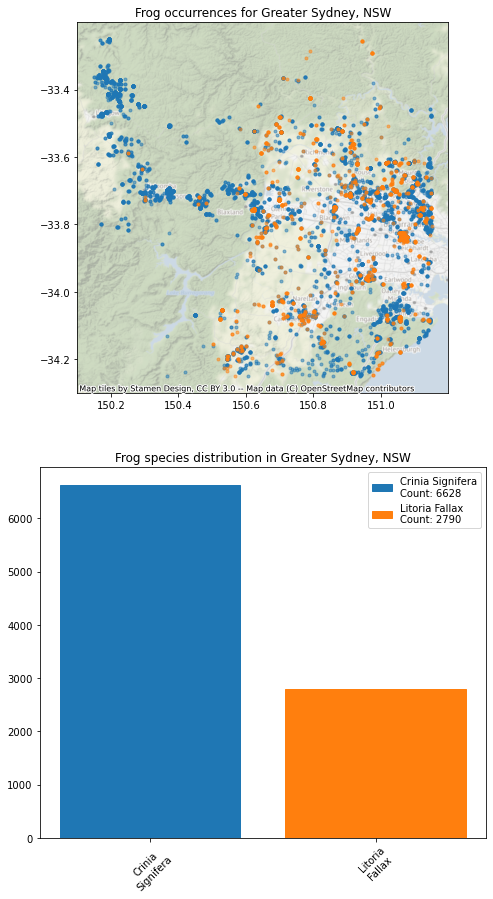

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

In [6]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax,1
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera,0
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax,1
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax,1
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera,0
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax,1
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax,1
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera,0


Text(0.5, 1.0, 'Balanced training set')

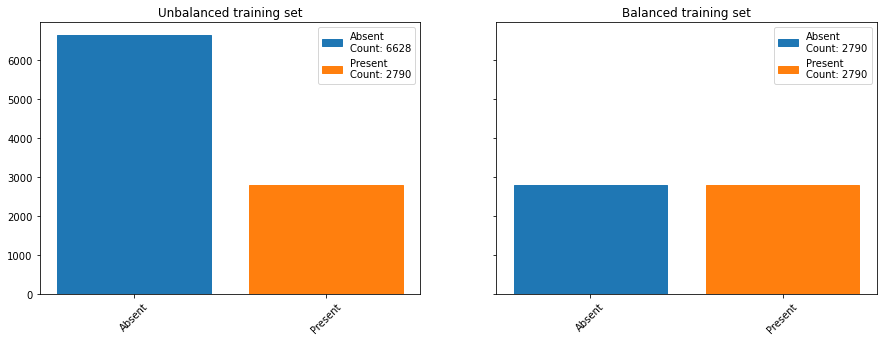

In [7]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

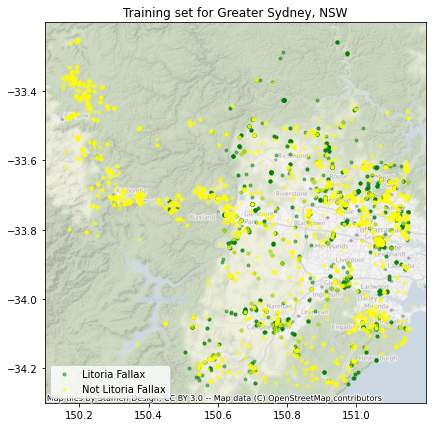

In [8]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

In [9]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    
 # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [10]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

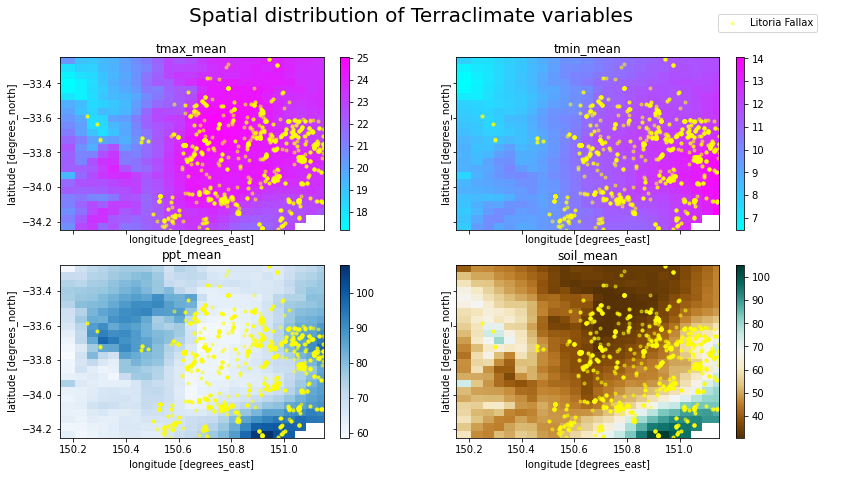

In [11]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

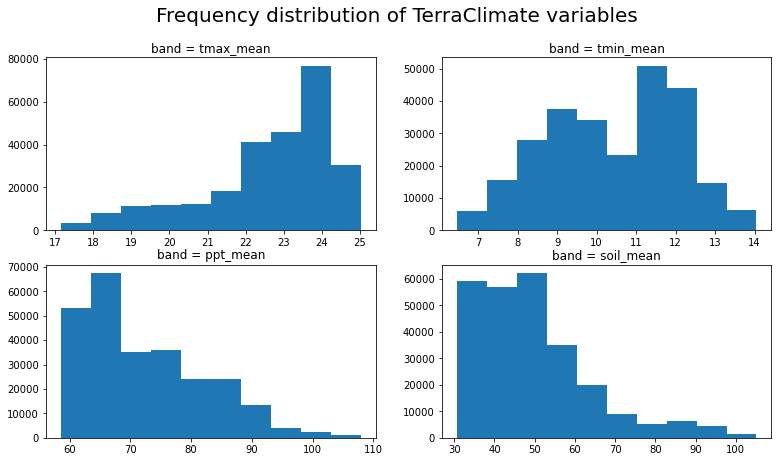

In [12]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

In [13]:
def join_frogs(frogs, data):

    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3463704693,2019-11-10,Australia,Australia,New South Wales,-33.466600,150.185000,Crinia Signifera,0,0,73.349998,65.083336,17.966669,7.081669
1,3463455363,2018-10-08,Australia,Australia,New South Wales,-33.833166,151.014700,Crinia Signifera,0,1,70.383331,50.116665,24.088335,13.050002
2,3463662977,2018-11-04,Australia,Australia,New South Wales,-33.714100,151.143000,Crinia Signifera,0,2,96.599998,74.966667,23.010002,12.643335
3,2806506373,2016-07-15,Australia,Australia,New South Wales,-33.907400,150.833720,Crinia Signifera,0,3,63.183334,44.816666,24.073334,11.728335
4,3463505407,2018-12-21,Australia,Australia,New South Wales,-33.759766,151.113259,Crinia Signifera,0,4,84.050003,65.483330,23.581669,13.054999


In [14]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

LogisticRegression()

In [15]:
predictions = full_model.predict(X)

In [16]:
def predict_frogs(predictor_image, model):
    
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
     # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

In [17]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.68
Accuracy: 0.65


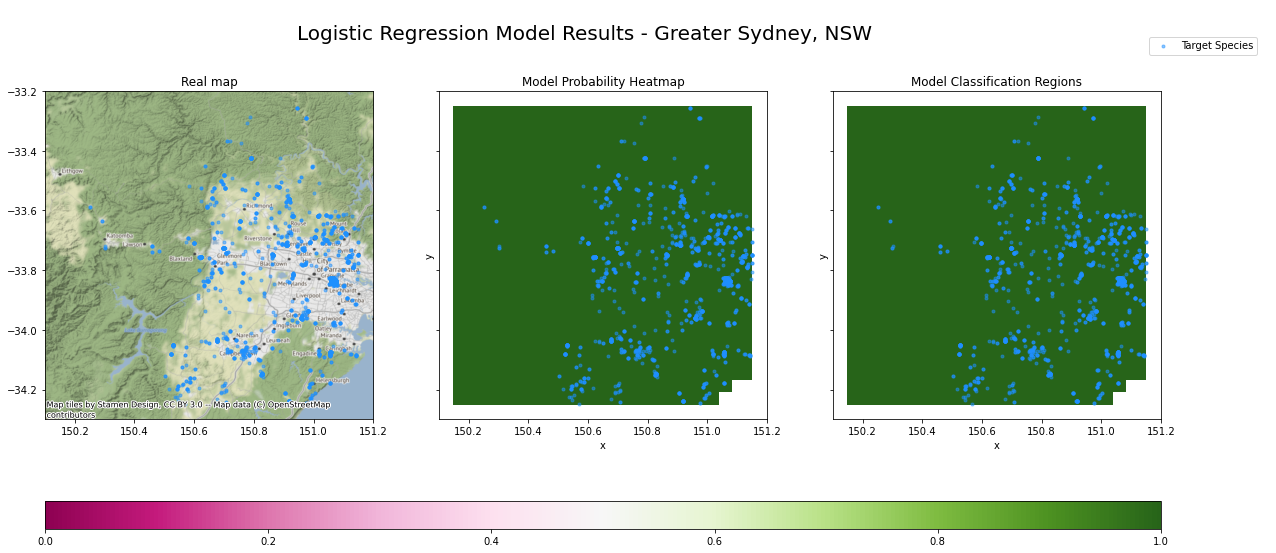

In [19]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')
# Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")


In [20]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.68
Accuracy: 0.65


In [22]:
test_file = pd.read_csv('Level_1_challenge_1_submission_template.csv')

In [68]:
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [69]:
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Loading data
Calculating mean
Calculating min
Calculating max


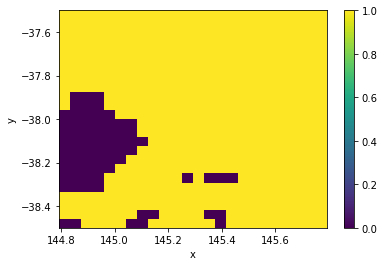

Loading data
Calculating mean
Calculating min
Calculating max


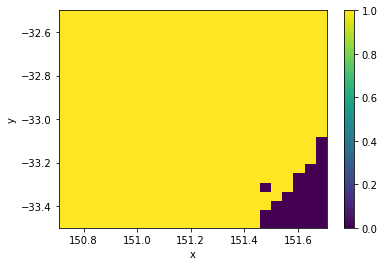

Loading data
Calculating mean
Calculating min
Calculating max


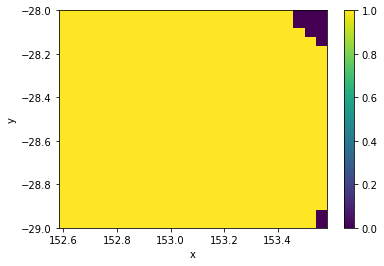

Loading data
Calculating mean
Calculating min
Calculating max


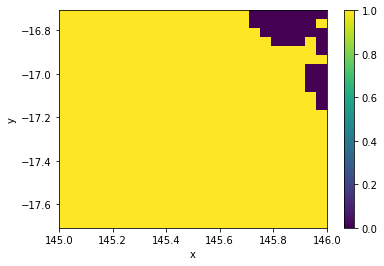

Loading data
Calculating mean
Calculating min
Calculating max


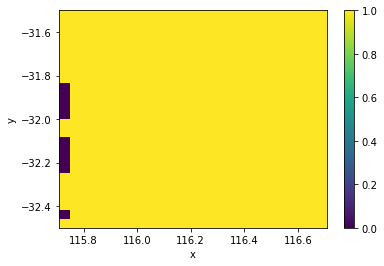

In [78]:
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()    

In [79]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)

In [80]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_benchmark.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,1
1,1,-37.770833,144.979167,1
2,2,-37.979167,145.354167,1
3,3,-37.604167,145.020833,1
4,4,-38.479167,145.645833,1
...,...,...,...,...
4046,4046,-31.895833,116.145833,1
4047,4047,-32.395833,115.770833,1
4048,4048,-32.145833,115.854167,1
4049,4049,-31.812500,116.229167,1


In [81]:
open('challenge_1_submission_benchmark.csv')

<_io.TextIOWrapper name='challenge_1_submission_benchmark.csv' mode='r' encoding='cp1252'>